### K-gap polynomial low degree $\alpha < 1$ 

estimator_names = ["naiveoracle", "haver", "avg", "max", "weightedms_4", "double"]
opt = (σ² = 0.25, dataseed = 313, algoseed = 789, n_trials = 200, N = 2000, algo_name = "uniform", problem_name = "K_gap_poly", K = 64, num_optimals = nothing, degree_ary = [0.2, 0.5, 0.7, 1.0, 2.0, 3.0, 5.0, 10.0], Delta = nothing, gap_splits = nothing)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


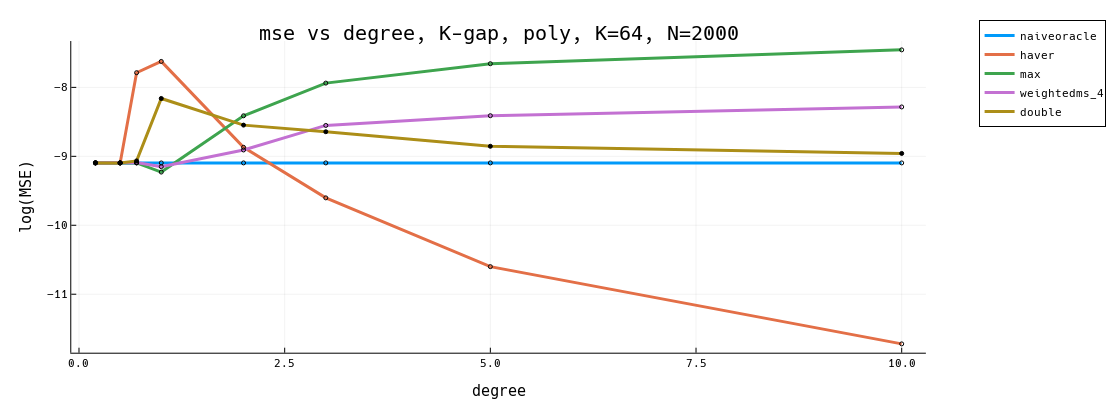

In [38]:
"""
trying to run bandits and see the performance of the estimator.

"""

using Infiltrator
using ProgressMeter
using Plots
plotly()

include("./KjBandits.jl")
include("./KjFunctions.jl")


opt = (
    σ² = (1.0/2)^2, 
    dataseed=313, #123
    algoseed=789,
    n_trials = 200, #50, #1000, #200
    N = 2000, 
    algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
    problem_name = "K_gap_poly", #"equal", "allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
    K = 64,
    num_optimals = nothing,
    degree_ary = [0.2, 0.5, 0.7, 1.0, 2.0, 3.0, 5.0, 10.0],
    Delta = nothing,
    gap_splits = nothing,
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["naiveoracle", "haver", "avg", "max", "weightedms_4", "double"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.degree_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_d in eachindex(opt.degree_ary)
        global problem, algo
        degree = opt.degree_ary[i_d]

        problem = problem_factory(
            opt.problem_name, opt.σ²,  myseed, 
            K=opt.K, num_optimals=opt.num_optimals, 
            degree=degree, Delta=opt.Delta, gap_splits=opt.gap_splits)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        data = zeros(opt.K, opt.N)
        for i in 1:opt.K
            algo.n_pulls[i] = opt.N
            rewards = problem.μ[i] .+ sqrt(problem.σ²)*randn(problem.rngs[i], opt.N) 
            algo.sum_rewards[i] = sum(rewards) 
            data[i,:] .= rewards
        end 
        
        for i_est in 1:length(estimators)-1
            hatvalues[i_try, i_d, i_est] = estimate_value(estimators[i_est], algo)
        end
        hatvalues[i_try, i_d, end] = estimate_value(estimators[end], data)
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)

x = opt.degree_ary
i = 1; plot(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
# i = 3; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
i = 4; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 5; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 6; plot!(x, log.(mse[:,i]), label=estimator_names[i], linewidth=3)

i = 1; scatter!(x, log.(mse[:,i]), label=nothing, color=nothing, markersize=2)
i = 2; scatter!(x, log.(mse[:,i]), label=nothing, color=nothing, markersize=2)
# i = 3; scatter!(x, log.(mse[:,i]), label=nothing, color=nothing, markersize=2)
i = 4; scatter!(x, log.(mse[:,i]), label=nothing, color=nothing, markersize=2)
i = 5; scatter!(x, log.(mse[:,i]), label=nothing, color=nothing, markersize=2)
i = 6; scatter!(x, log.(mse[:,i]), label=nothing, color="black", markersize=2)
plot!(xlabel="degree", ylabel="log(MSE)", legend=:outertopright)  
title!("mse vs degree, K-gap, poly, K=64, N=2000")


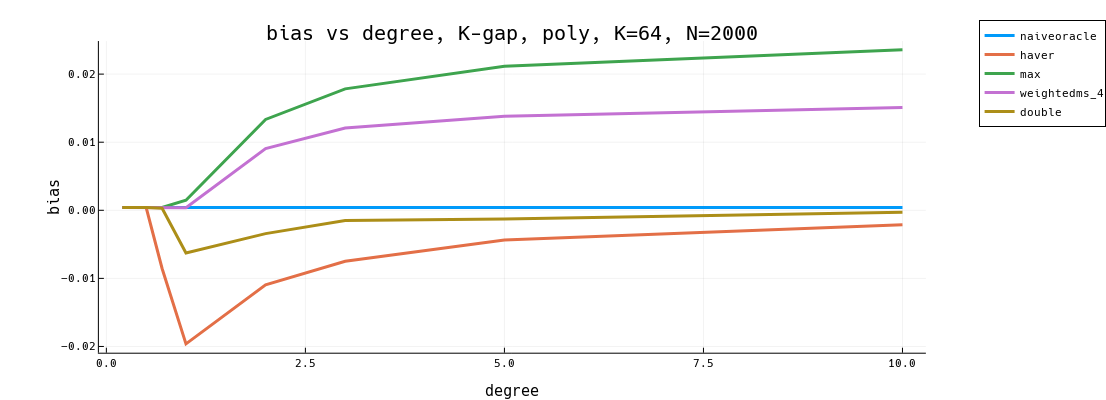

In [40]:
x = opt.degree_ary
i = 1; plot(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
# i = 3; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
i = 6; plot!(x, bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="degree", ylabel="bias", legend=:outertopright)  
title!("bias vs degree, K-gap, poly, K=64, N=2000")